In [2]:
import api as papi
import pandas as pd
import batch_crawl as bc
import requests
import seaborn as sns
import os
from tqdm import tqdm

In [ ]:
from constants import *

# Crawl all pets

In [4]:
TOTAL_PETS = 1000
PAGE_SIZE = 50
PETS_FILE = "test/pets.csv"
pets = {
    "id": [],
    "name": [],
}

for batch in tqdm(range(0, TOTAL_PETS, PAGE_SIZE), desc="Fetching pets data"):
    pets_batch = papi.get_actives(offset=batch, limit=PAGE_SIZE)
    for pet in pets_batch:
        pets["id"].append(pet.id)
        pets["name"].append(pet.name)
        
df = pd.DataFrame(pets)
df.to_csv(PETS_FILE, index=False)

Fetching pets data: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


# Crawl total photos of pets

In [5]:
pets = pd.read_csv(PETS_FILE)
pets_ids = pets["id"].tolist()

pets_total_photos = {
    "id": [],
    "total_photos": [],
}

for pet_id in tqdm(pets_ids, desc="Fetching pets total photos"):
    total_photos = papi.get_total_photos(pet_id)
    pets_total_photos["id"].append(pet_id)
    pets_total_photos["total_photos"].append(total_photos)

Fetching pets total photos: 100%|██████████| 1000/1000 [15:21<00:00,  1.09it/s]


In [14]:
df = pd.DataFrame(pets_total_photos)
df.to_csv(PETS_TOTAL_PHOTOS_FILE, index=False)

# Get desired pets

<Axes: xlabel='total_photos'>

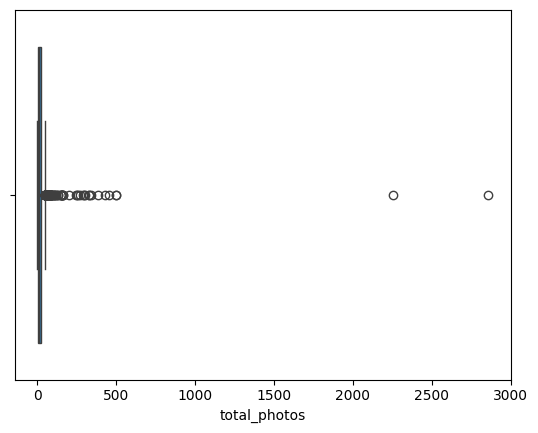

In [3]:
pets_total_photos = pd.read_csv(PETS_TOTAL_PHOTOS_FILE)
# plot total photos distribution
sns.boxplot(x=pets_total_photos["total_photos"])

In [12]:
pets_total_photos.describe()

,id,total_photos
count,1000.000000,1000.000000
mean,374888.595000,26.994000
std,86164.227173,123.426618
min,467.000000,0.000000
25%,309583.500000,5.000000
50%,347310.500000,10.000000
75%,441823.250000,21.000000
max,594914.000000,2859.000000


In [ ]:
filtered_pest = pets_total_photos[pets_total_photos["total_photos"] > 20]

,id,total_photos
0,328282,2253
1,344026,497
2,276257,325
3,320532,39
4,313004,88
...,...,...
940,304924,26
953,428373,23
958,332783,24
987,305056,23


In [14]:
DESIRED_PETS = 200

In [15]:
# get random pets
selected_pets = filtered_pest.sample(n=DESIRED_PETS)
selected_pets.to_csv(SELECTED_PETS_FILE, index=False)

# Crawl pets' details

In [3]:
DESIRED_PET_PHOTOS = 20

In [4]:
selected_pets = pd.read_csv(SELECTED_PETS_FILE, header=0)
selected_pets_ids = selected_pets["id"].tolist()

photos = {
    "id": [],
    "pet_id": [],
    "url": [],
}

for pet_id in tqdm(selected_pets_ids, desc="Fetching pet photos"):
    pet_total_photos = papi.get_total_photos(pet_id)
    photo_batches = bc.get_crawl_batches(pet_total_photos, DESIRED_PET_PHOTOS, batch_size=50)
    try:
        for batch in photo_batches:
            try:
                photos_batch = papi.get_photos(pet_id, limit=batch.limit, offset=batch.offset)
                indices = batch.page_indices
                for idx in indices:
                    photos["id"].append(photos_batch[idx].id)
                    photos["pet_id"].append(pet_id)
                    photos["url"].append(photos_batch[idx].url)
            except papi.PetPhotoForbiddenException:
                raise
                    
            except Exception as e:
                print(f"Error fetching photos for pet {pet_id}: {e}")
                pass
        
    except papi.PetPhotoForbiddenException:
        print(f"Skipping pet {pet_id} due to forbidden photos")
        continue
            

Fetching pet photos:   8%|▊         | 15/200 [00:30<06:06,  1.98s/it]

Skipping pet 94792 due to forbidden photos


Fetching pet photos:  29%|██▉       | 58/200 [01:49<04:46,  2.02s/it]

Skipping pet 332392 due to forbidden photos


Fetching pet photos:  66%|██████▌   | 132/200 [04:19<02:09,  1.91s/it]

Skipping pet 320100 due to forbidden photos


Fetching pet photos:  70%|███████   | 140/200 [04:32<01:33,  1.55s/it]

Skipping pet 318566 due to forbidden photos


Fetching pet photos:  75%|███████▌  | 150/200 [04:55<01:51,  2.23s/it]

Skipping pet 317512 due to forbidden photos


Fetching pet photos:  90%|█████████ | 180/200 [06:08<00:32,  1.63s/it]

Skipping pet 291860 due to forbidden photos


Fetching pet photos: 100%|██████████| 200/200 [06:42<00:00,  2.01s/it]


In [5]:
df = pd.DataFrame(photos)
df.to_csv(SELECTED_PETS_PHOTOS_FILE, index=False)

# Download photos

In [4]:
photos = pd.read_csv(SELECTED_PETS_PHOTOS_FILE)
def get_pet_folder(pet_id):
    return f"{PHOTOS_FOLDER}/{pet_id}"

# group photos by pet_id
grouped = photos.groupby("pet_id")

# create folder for each pet
for pet_id in photos["pet_id"].unique():
    folder = get_pet_folder(pet_id)
    if not os.path.exists(folder):
        os.makedirs(folder)
        
# download photos
for pet_id, group in tqdm(grouped, desc="Downloading photos"):
    folder = get_pet_folder(pet_id)
    for idx, row in group.iterrows():
        photo_id = row["id"]
        photo_url = row["url"]
        photo_path = f"{folder}/{photo_id}.jpg"
        if not os.path.exists(photo_path):
            try:
                response = requests.get(photo_url)
                with open(photo_path, "wb") as f:
                    f.write(response.content)
            except Exception as e:
                print(f"Error downloading photo {photo_id} for pet {pet_id}: {e}")
                pass